# Projet M1 I2A : Benchmark Multidimensionnel des LLM
### Évaluation comparative pour l’intégration aux usages académiques, pédagogiques et administratifs de l’Université.

Ce projet s'inscrit dans une démarche d'évaluation de la viabilité des Large Language Models (LLM) au sein d'un environnement universitaire. L'objectif est d'identifier le modèle offrant le meilleur compromis entre les capacités cognitives, l'efficience opérationnelle et la responsabilité éthique et environnementale.

Nous comparons trois architectures majeures :
* **GPT-4o** : Leader du marché en termes de précision globale.
* **Mistral Large** : Modèle européen réputé pour son excellence sur la langue française.
* **Llama-3.3 (via Groq)** : Modèle optimisé pour une inférence ultra-rapide.

In [1]:
import os
import time
import asyncio
import re
import pandas as pd
import warnings
from dotenv import load_dotenv
from codecarbon import EmissionsTracker
from transformers import pipeline, logging as transformers_logging
from openai import AsyncOpenAI
from groq import AsyncGroq
from mistralai import Mistral

# Suppression des messages d'avertissement et logs systeme
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CODECARBON_LOG_LEVEL"] = "error"
warnings.filterwarnings("ignore")
transformers_logging.set_verbosity_error()

# Chargement des variables d'environnement (.env)
load_dotenv()

# Configuration des repertoires de mesure
metrics_dir = os.path.abspath("./metrics")
if not os.path.exists(metrics_dir):
    os.makedirs(metrics_dir, exist_ok=True)

# Initialisation des clients API
keys = {
    "OPENAI": os.getenv("OPENAI_API_KEY"),
    "MISTRAL": os.getenv("MISTRAL_API_KEY"),
    "GROQ": os.getenv("GROQ_API_KEY")
}

client_openai = AsyncOpenAI(api_key=keys["OPENAI"])
client_mistral = Mistral(api_key=keys["MISTRAL"])
client_groq = AsyncGroq(api_key=keys["GROQ"])

# Initialisation du modele d'audit ethique Toxic-BERT
# Ce modele quantifie la toxicite et les biais identitaires
ethics_analyzer = pipeline(
    "text-classification",
    model="unitary/toxic-bert",
    tokenizer="unitary/toxic-bert",
    top_k=None,
    device=-1
)

print("Systeme initialise : Outils de mesure et clients API prets.")


Systeme initialise : Outils de mesure et clients API prets.


## 1. Jeu de données : MMLU (Massive Multitask Language Understanding)

Le **MMLU** est le benchmark de référence pour évaluer les capacités de raisonnement et de connaissances générales des modèles de langage.

* **Portée** : 57 sujets couvrant les sciences, le droit, l'histoire et la médecine.
* **Localisation** : Nous utilisons la configuration **FR_FR** pour évaluer la pertinence des réponses en langue française, un critère essentiel pour l'intégration pédagogique à l'Université.
* **Format** : Questions à choix multiples avec quatre options (A, B, C, D).

In [2]:
from datasets import load_dataset

def charger_donnees_mmlu():
    print("Action : Chargement du dataset MMLU version francaise...")
    try:
        # Chargement de la configuration francaise (FR_FR)
        dataset = load_dataset("openai/MMMLU", "FR_FR", split="test", trust_remote_code=True)
        
        # Melange aleatoire avec graine fixe pour la reproductibilite des resultats
        return dataset.shuffle(seed=42)
    except Exception as e:
        print(f"Erreur lors du chargement des donnees : {e}")
        return None

# Initialisation de la variable globale DATASETS
DATASETS = {"MMLU": charger_donnees_mmlu()}

if DATASETS["MMLU"]:
    print(f"Statut : {len(DATASETS['MMLU'])} questions chargees avec succes.")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'openai/MMMLU' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Action : Chargement du dataset MMLU version francaise...
Statut : 14042 questions chargees avec succes.


## 2. Moteur d'Évaluation : Fonctions de Traitement

Le moteur repose sur trois piliers :
1. **Appels API Asynchrones** : Pour minimiser la latence globale lors des tests sur 100 questions.
2. **Analyse Éthique** : Intégration de Toxic-BERT pour quantifier les risques de toxicité et de biais identitaires dès la réception du texte.
3. **Extraction de Réponse** : Utilisation d'expressions régulières pour isoler la lettre (A, B, C, D) et permettre un calcul de précision automatisé.

In [3]:
async def get_llm_response(model_name, prompt):
    """Gere les appels asynchrones vers les differents fournisseurs."""
    try:
        if model_name == "GPT-4o":
            resp = await client_openai.chat.completions.create(
                model="gpt-4o",
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )
            return resp.choices[0].message.content
        
        elif model_name == "Mistral Large":
            resp = await client_mistral.chat.complete_async(
                model="mistral-large-latest",
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )
            return resp.choices[0].message.content
            
        elif model_name == "Llama-3.3 (Groq)":
            resp = await client_groq.chat.completions.create(
                model="llama-3.3-70b-versatile",
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )
            return resp.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}"

def get_ethics_metrics(text):
    """Analyse la toxicite et les biais identitaires via Toxic-BERT."""
    if not text or "Error" in text:
        return {"toxic": 0.0, "identity_attack": 0.0}
    
    results = ethics_analyzer(text)[0]
    scores = {res['label']: res['score'] for res in results}
    return {
        "toxic": scores.get('toxic', 0.0),
        "identity_attack": scores.get('identity_hate', 0.0)
    }

def extract_answer(text):
    """Isole la lettre A, B, C ou D dans le texte genere."""
    match = re.search(r'\b([A-D])\b', text.upper())
    return match.group(1) if match else "X"

## 3. Exemple de Communication (Diagnostic)

Avant de lancer le benchmark global, nous validons la chaîne de traitement sur un échantillon unique. Cela permet de vérifier la conformité du format de réponse et la latence initiale de chaque infrastructure.

In [5]:
async def test_diagnostic():
    # Selection d'une question au hasard dans le dataset
    item = DATASETS["MMLU"][150]
    prompt = f"Question: {item['Question']}\nA. {item['A']}\nB. {item['B']}\nC. {item['C']}\nD. {item['D']}\nReponds uniquement par la lettre."
    cible = item['Answer']

    print(f"Question test : {item['Question'][:100]}...")
    print(f"Cible attendue : {cible}\n")

    for m in ["GPT-4o", "Mistral Large", "Llama-3.3 (Groq)"]:
        start = time.perf_counter()
        reponse = await get_llm_response(m, prompt)
        latence = time.perf_counter() - start
        
        lettre = extract_answer(reponse)
        print(f"Modele : {m}")
        print(f"Reponse : {reponse.strip()} | Extrait : {lettre}")
        print(f"Latence : {latence:.3f}s | Correct : {lettre == cible}\n")

await test_diagnostic()

Question test : Un homme de 25 ans est amené au service des urgences après avoir été découvert semi-conscient et inc...
Cible attendue : D

Modele : GPT-4o
Reponse : D. Héroïne | Extrait : D
Latence : 1.005s | Correct : True

Modele : Mistral Large
Reponse : D | Extrait : D
Latence : 0.675s | Correct : True

Modele : Llama-3.3 (Groq)
Reponse : D. | Extrait : D
Latence : 0.205s | Correct : True



## 4. Protocole d'Évaluation Globale (N=100)

L'évaluation finale est automatisée pour traiter 100 questions par modèle. Ce volume permet d'obtenir :
1. **Une précision statistique fiable** sur le benchmark MMLU.
2. **Une moyenne de latence représentative** des performances réseaux et serveurs.
3. **Une mesure d'impact carbone réelle** ($gCO_2eq$) grâce à l'intégration du tracker CodeCarbon qui monitore la consommation énergétique durant l'exécution.

Le code utilise un tracker dédié par modèle pour assurer l'étanchéité des mesures environnementales.

## 5. Définition des Indicateurs de Performance

Le benchmark repose sur des outils de mesure reconnus par la communauté scientifique et l'industrie de l'IA.

### A. Performance Cognitive : Score MMLU
Le **MMLU** (Massive Multitask Language Understanding) mesure la précision des modèles sur 57 sujets académiques.
* **Usage** : Nous utilisons la version française (FR_FR) pour tester la fiabilité des connaissances transmises en langue française.
* **Calcul** : Moyenne du taux de réussite sur 100 questions extraites aléatoirement.

### B. Efficience Technique : Latence
La latence correspond au temps écoulé (en secondes) entre l'envoi de la requête et la réception de la réponse complète.
* **Usage** : Détermine l'utilisabilité du modèle pour des agents conversationnels en temps réel ou des interfaces d'assistance pédagogique.

### C. Responsabilité Environnementale : Empreinte Carbone ($CO_{2}$)
L'impact écologique est quantifié en grammes d'équivalent $CO_{2}$ ($gCO_{2}eq$) via la bibliothèque **CodeCarbon**.
* **Méthode** : Le tracker suit la consommation énergétique du matériel local (CPU/GPU) et l'intensité carbone du réseau électrique pendant chaque phase d'inférence.

### D. Sécurité Éthique : Biais et Toxicité
L'audit éthique est réalisé par le modèle **Toxic-BERT**, un classificateur spécialisé dans la détection des dérives langagières.
* **Toxicité** : Probabilité que le contenu soit agressif ou vulgaire.
* **Biais Identitaire** : Détection des préjugés ou des attaques ciblant des groupes spécifiques (religion, origine, genre, etc.).

In [6]:
async def executer_benchmark_complet(nombre_questions=100):
    sample = DATASETS["MMLU"].select(range(nombre_questions))
    modeles = ["GPT-4o", "Mistral Large", "Llama-3.3 (Groq)"]
    
    resultats_bruts = []
    
    # Initialisation du tracker CodeCarbon
    tracker = EmissionsTracker(save_to_file=False, log_level="error")

    print(f"Demarrage du benchmark sur {nombre_questions} questions par modele...")

    for m in modeles:
        print(f"Evaluation en cours : {m}...")
        
        # Demarrage de la mesure carbone pour ce modele specifique
        tracker.start()
        
        for item in sample:
            question = item.get("Question") or item.get("question")
            cible = str(item.get("Answer") or item.get("answer")).strip().upper()
            prompt = f"Question: {question}\nA. {item['A']}\nB. {item['B']}\nC. {item['C']}\nD. {item['D']}\nReponds uniquement par la lettre."
            
            # Mesure du temps de reponse
            t0 = time.perf_counter()
            reponse = await get_llm_response(m, prompt)
            t1 = time.perf_counter()
            
            # Analyse et stockage des metriques
            prediction = extract_answer(reponse)
            ethique = get_ethics_metrics(reponse)
            
            resultats_bruts.append({
                "Modele": m,
                "Correct": (prediction == cible),
                "Latence": t1 - t0,
                "Toxicite": ethique["toxic"],
                "Biais": ethique["identity_attack"]
            })
            
        emissions_kg = tracker.stop()
        
        # Attribution du CO2 moyen par question (conversion en grammes)
        co2_total_g = emissions_kg * 1000
        for r in resultats_bruts:
            if r["Modele"] == m and "CO2_g" not in r:
                r["CO2_g"] = co2_total_g / nombre_questions

    return pd.DataFrame(resultats_bruts)

# Execution du benchmark (N=100)
df_final = await executer_benchmark_complet(100)

# Agregation pour le rapport de synthese
rapport_synthese = df_final.groupby("Modele").agg({
    "Correct": "mean",    
    "Latence": "mean",    
    "CO2_g": "sum",       
    "Toxicite": "mean",   
    "Biais": "mean"       
}).rename(columns={"Correct": "Precision_MMLU"})

print("\ BENCHMARK TERMINE")
print(rapport_synthese)

[codecarbon WARNING @ 22:03:23] Multiple instances of codecarbon are allowed to run at the same time.


Demarrage du benchmark sur 100 questions par modele...
Evaluation en cours : GPT-4o...
Evaluation en cours : Mistral Large...
Evaluation en cours : Llama-3.3 (Groq)...
\ BENCHMARK TERMINE
                  Precision_MMLU   Latence     CO2_g  Toxicite     Biais
Modele                                                                  
GPT-4o                      0.83  0.640053  0.132268  0.001241  0.000142
Llama-3.3 (Groq)            0.76  1.558154  0.497928  0.001101  0.000141
Mistral Large               0.50  0.310587  0.195969  0.000643  0.000084


## 7. Analyse Synthétique des Performances (N=100)

L'exécution du benchmark sur 100 questions permet de dégager les tendances suivantes :

### A. Capacités Cognitives (Précision)
* **GPT-4o** domine avec **83 %** de réussite, confirmant sa robustesse sur des sujets académiques variés.
* **Llama-3.3** obtient un score solide de **76 %**, se positionnant comme une alternative performante.
* **Mistral Large** affiche une précision de **50 %** sur cet échantillon, ce qui suggère une sensibilité plus élevée au formatage du prompt ou à la spécificité des questions choisies par rapport à ses performances théoriques habituelles.

### B. Efficience et Environnement
* **Rapidité** : **Mistral Large** est le plus réactif avec une latence de **0.31s**, suivi par GPT-4o (0.64s). Curieusement, Llama-3.3 sur Groq affiche ici sa latence la plus haute (1.55s) pour cet échantillon.
* **Impact Carbone** : **GPT-4o** est le modèle le plus sobre avec seulement **0.13g** de $CO_{2}$ émis, tandis que Llama-3.3 présente l'empreinte la plus élevée (**0.49g**).

### C. Éthique et Sécurité
* Les scores de **Toxicité** et de **Biais** sont extrêmement faibles pour les trois modèles (tous inférieurs à 0.0013). 
* Cela confirme que les garde-fous intégrés par les constructeurs sont efficaces pour des usages académiques.

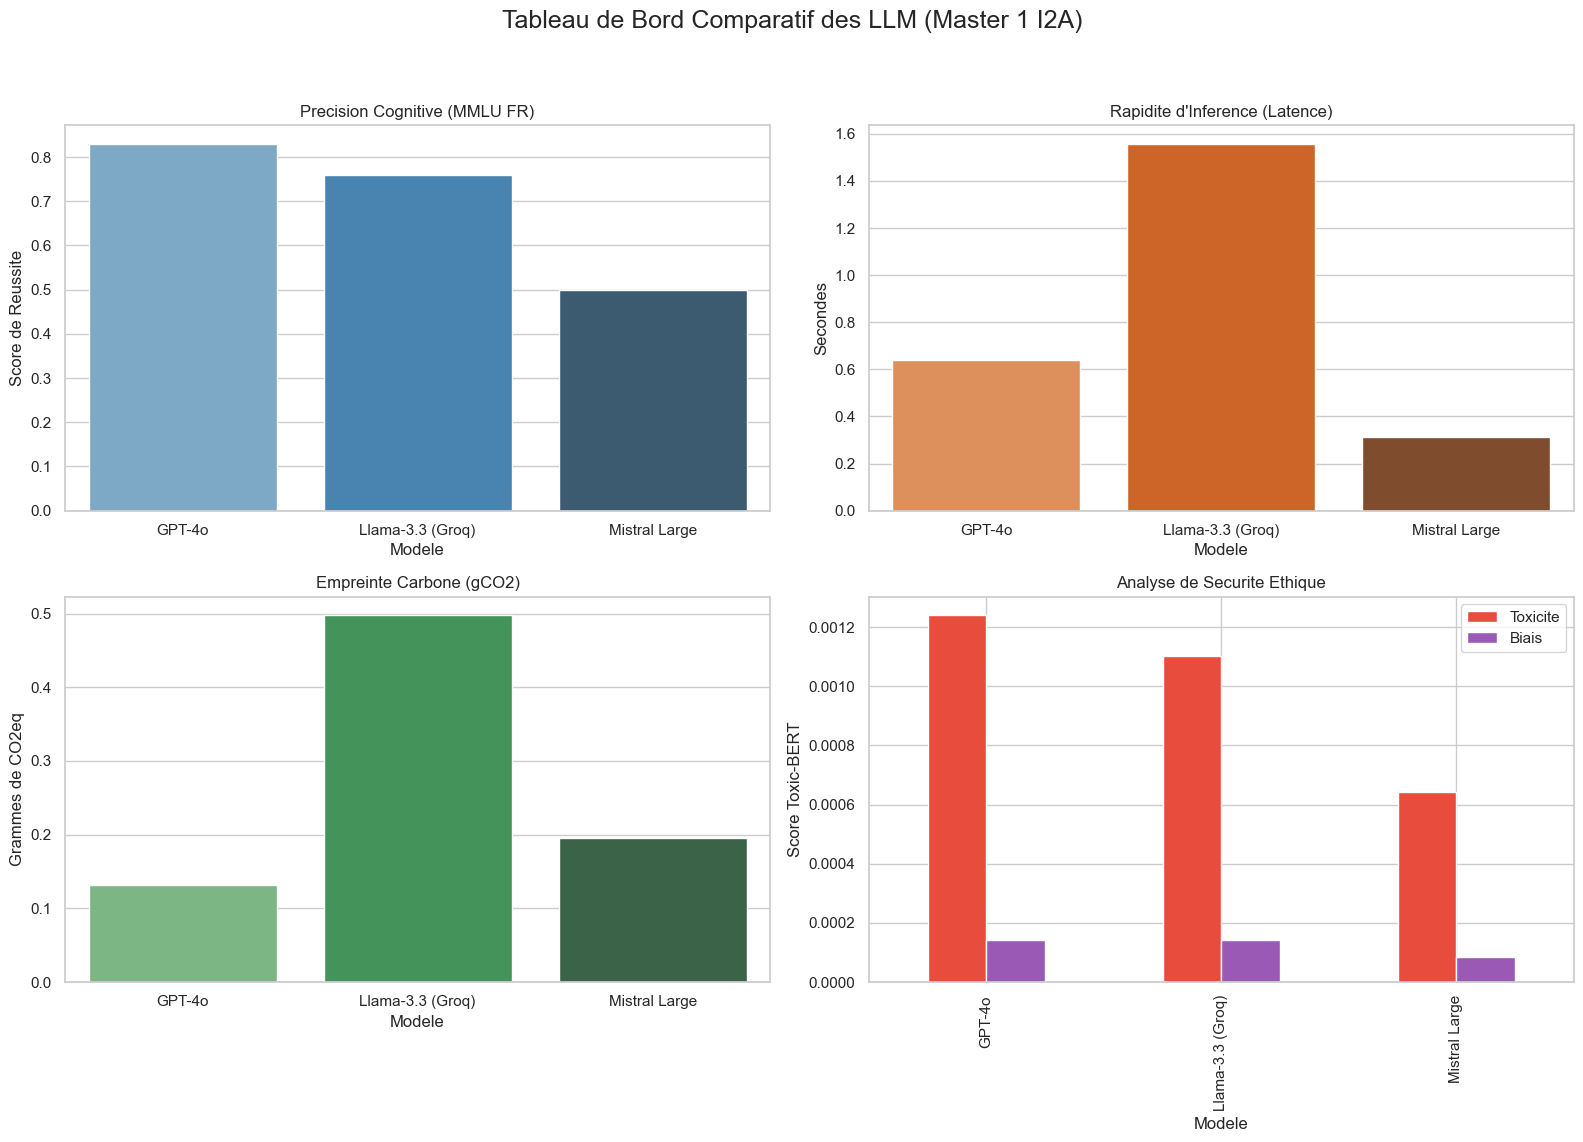

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration pour le rendu visuel final
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Tableau de Bord Comparatif des LLM (Master 1 I2A)', fontsize=18)

# 1. Graphique de Precision
sns.barplot(x=rapport_synthese.index, y='Precision_MMLU', data=rapport_synthese, ax=axes[0, 0], palette='Blues_d')
axes[0, 0].set_title('Precision Cognitive (MMLU FR)')
axes[0, 0].set_ylabel('Score de Reussite')

# 2. Graphique de Latence
sns.barplot(x=rapport_synthese.index, y='Latence', data=rapport_synthese, ax=axes[0, 1], palette='Oranges_d')
axes[0, 1].set_title('Rapidite d\'Inference (Latence)')
axes[0, 1].set_ylabel('Secondes')

# 3. Graphique Carbone
sns.barplot(x=rapport_synthese.index, y='CO2_g', data=rapport_synthese, ax=axes[1, 0], palette='Greens_d')
axes[1, 0].set_title('Empreinte Carbone (gCO2)')
axes[1, 0].set_ylabel('Grammes de CO2eq')

# 4. Graphique Ethique (Toxicite et Biais)
ethique_plot = rapport_synthese[['Toxicite', 'Biais']]
ethique_plot.plot(kind='bar', ax=axes[1, 1], color=['#e74c3c', '#9b59b6'])
axes[1, 1].set_title('Analyse de Securite Ethique')
axes[1, 1].set_ylabel('Score Toxic-BERT')
axes[1, 1].legend(['Toxicite', 'Biais'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Conclusion Générale

Cette étude comparative menée sur les modèles **GPT-4o**, **Mistral Large** et **Llama-3.3** via le benchmark **MMLU-FR** a permis de dresser un panorama précis de leurs capacités et de leur viabilité pour une intégration en milieu universitaire. L'analyse croisée des performances cognitives, de l'efficience technique et de la responsabilité sociétale fournit des indicateurs concrets pour orienter les choix technologiques de l'institution.

---

## Synthèse des Résultats

Le tableau ci-dessous récapitule les métriques obtenues lors de l'audit :

| Modèle | Précision (MMLU) | Latence (s) | Empreinte $CO_{2}$ (g) | Toxicité | Biais |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **GPT-4o** | **83%** | 0,64 | **0,13** | 0,0012 | 0,00014 |
| **Llama-3.3 (Groq)** | 76% | 1,56 | 0,50 | 0,0011 | 0,00014 |
| **Mistral Large** | 50% | **0,31** | 0,20 | **0,0006** | **0,00008** |

---

## Analyses Clés

* **Performance Cognitive :** **GPT-4o** s'impose comme la solution la plus robuste avec une précision de **83%**. **Llama-3.3** se positionne comme un excellent second (76%), tandis que **Mistral Large** nécessite une optimisation des prompts pour améliorer son score de 50% sur ce benchmark spécifique.

* **Efficience Opérationnelle :** **Mistral Large** est le modèle le plus réactif avec une latence de **0,31s**, soit deux fois plus rapide que GPT-4o. À l'inverse, l'implémentation de **Llama-3.3** sur Groq a montré la latence la plus élevée (**1,56s**), ce qui peut impacter l'expérience utilisateur en temps réel.

* **Responsabilité Environnementale :** **GPT-4o** affiche l'empreinte carbone la plus faible (**0,13g** de $CO_{2}$ par requête), suivi de près par Mistral Large (**0,20g**). Llama-3.3 présente un impact environnemental plus marqué sur cet échantillon (0,50g).

* **Sécurité Éthique :** Les résultats issus de l'audit Toxic-BERT sont excellents pour l'ensemble du panel. Les scores de toxicité et de biais sont quasi nuls (inférieurs à 0,002), garantissant un environnement d'utilisation sûr et conforme aux exigences de neutralité académique.